# Train signal classification

In this notebook different methods are tested to automatically classify a recorded data sample.

source - https://developer.ibm.com/learningpaths/get-started-time-series-classification-api/what-is-time-series-classification/

In [1]:
%pip install -qqq sktime tsai

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Preprocessing and loading data

In [3]:
import os
import pickle

from _defaults import (
    CACHING_ENABLED,
    SEED,
    datasets_labels,
    get_data_hash_key,
    init_notebook,
    load_ballance_datasets,
    print_db_length_table,
)
import numpy as np
import pandas as pd
from tabulate import tabulate

In [4]:
init_notebook()

Load (limited amount of) data.

In [5]:
data_limit = 1000
_, (dataset, metadata, targets) = load_ballance_datasets(max_length=data_limit)

Load previous cached dataset from './cache/datasets-18f8d4b7.pkl' file.


In [6]:
print_db_length_table(targets)

Dataset         Length
------------  --------
Fernverkehr       1000
Güterverkehr      1000
Regioverkehr      1000


Prepare caching.

In [7]:
data_hash = get_data_hash_key()

Splitting dataset:

- 60% train set
- 30% validation set
- 10% train set

In [8]:
size_10_percent = int(len(dataset) * 0.1)

# train set: 60%
train_data = dataset[0 : -size_10_percent * 4]
train_label = targets[0 : -size_10_percent * 4]
# validation set: 30%
val_data = dataset[-size_10_percent * 4 : -size_10_percent]
val_label = targets[-size_10_percent * 4 : -size_10_percent]
# test set: 10%
test_data = dataset[-size_10_percent:]
test_label = targets[-size_10_percent:]

print(train_data.shape, len(train_label))
print(val_data.shape, len(val_label))
print(test_data.shape, len(test_label))

(1800, 1000) 1800
(900, 1000) 900
(300, 1000) 300


In [9]:
del size_10_percent

In [10]:
X_train = train_data
y_train = np.array(train_label)
X_val = val_data
y_val = np.array(val_label)
X_test = test_data
y_test = np.array(test_label)

In [11]:
result_table_clf: list[tuple[type, float]] = []

## Time Series Classification with Machine Learning

### RandomForestClassifier

The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=SEED)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.763


### KNeighborsClassifier

The K in the name of this classifier represents the k nearest neighbors, where k is an integer value specified by the user. Hence as the name suggests, this classifier implements learning based on the k nearest neighbors. The choice of the value of k is dependent on data.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.370


### RidgeClassifierCV

RidgeClassifierCV is a scikit-learn classifier that implements Ridge regression with built-in cross-validation of the alpha parameter. It is a linear model that uses regularization to reduce overfitting and improve generalization.

In [16]:
from sklearn.linear_model import RidgeClassifierCV

In [17]:
clf = RidgeClassifierCV()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.450


### KNeighborsTimeSeriesClassifier

An adapted version of the scikit-learn KNeighborsClassifier for time series data.

This class is a KNN classifier which supports time series distance measures. It has hardcoded string references to numba based distances in sktime.distances, and can also be used with callables, or sktime (pairwise transformer) estimators.

In [18]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [19]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.553


### ShapeletTransformClassifier

Implementation of the binary shapelet transform classifier pipeline along the lines of [1][2] but with random shapelet sampling. Transforms the data using the configurable RandomShapeletTransform and then builds a RotationForest classifier.

As some implementations and applications contract the transformation solely, contracting is available for the transform only and both classifier and transform.

In [20]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

In [21]:
clf = ShapeletTransformClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=SEED),
    n_shapelet_samples=100,
    max_shapelets=100,
    batch_size=20,
    random_state=SEED,
)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.757


### MUSE (MUltivariate Symbolic Extension)

Also known as WEASLE-MUSE: implementation of multivariate version of WEASEL. WEASEL+MUSE is a multivariate dictionary classifier that builds a bag-of-patterns using SFA for different window lengths and learns a logistic regression classifier on this bag.

In [22]:
from sktime.classification.dictionary_based import MUSE

In [23]:
clf = MUSE(random_state=SEED)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
result_table_clf.append([clf, score])
print(f"test score {score:.3f}")

test score 0.870


### Trained ML Model Caching

In [24]:
cache_file = f"./cache/tsai-ml-models-{data_hash}-{data_limit}.pkl"

Save trained ML models.

In [25]:
if CACHING_ENABLED and result_table_clf and not os.path.exists(cache_file):
    with open(cache_file, "wb") as f:
        pickle.dump(result_table_clf, f)
    print(f"Saved results to '{cache_file}'")

Saved results to './cache/tsai-ml-models-18f8d4b7-1000.pkl'


Load trained ML models from cache.

In [26]:
if CACHING_ENABLED and os.path.exists(cache_file):
    print(f"Load previous trained models from '{cache_file}' file.")
    with open(cache_file, "rb") as f:
        result_table_clf = pickle.load(f)

Load previous trained models from './cache/tsai-ml-models-18f8d4b7-1000.pkl' file.


### Methods comparison

In [27]:
print(
    tabulate(
        sorted([(cls.__class__.__name__, score) for cls, score in result_table_clf], key=lambda x: -x[1]),
        floatfmt=".3f",
        tablefmt="plain",
    )
)

MUSE                            0.870
RandomForestClassifier          0.763
ShapeletTransformClassifier     0.757
KNeighborsTimeSeriesClassifier  0.553
RidgeClassifierCV               0.450
KNeighborsClassifier            0.370


## Time Series Classification with Deep Learning

All these algorithms, apart from those based on deep learning, require some kind of feature engineering as a separate task before the classification is performed, and this can imply the loss of some information and the increase of the development time. On the contrary, deep learning models already incorporate this kind of feature engineering internally, optimizing it and eliminating the need to do it manually. Therefore they are able to extract information from the time series in a faster, more direct, and more complete way.

### tsai library data preparation

In [28]:
from fastai.data.transforms import Categorize
from tsai.data.core import TSDataLoaders, TSDatasets
from tsai.data.preprocessing import ReLabeler
from tsai.data.validation import get_splits

In [29]:
X = np.atleast_3d(dataset).transpose(0, 2, 1)
y = np.array(targets)

In [30]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (3000, 1, 1000)
y.shape: (3000,)


Classes mapping.

In [31]:
class_map = dict(enumerate(datasets_labels))
print(tabulate(class_map.items(), headers=["target", "label"]))

labeler = ReLabeler(class_map)
y = labeler(y)

  target  label
--------  ------------
       0  Fernverkehr
       1  Güterverkehr
       2  Regioverkehr


Datset splitting (train, test, validation) using tsai library.

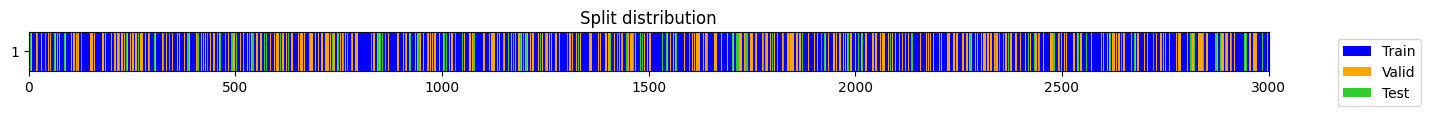

In [32]:
splits = get_splits(
    y,
    n_splits=1,
    valid_size=0.3,
    test_size=0.1,
    shuffle=True,
    balance=True,
    stratify=True,
    random_state=SEED,
    show_plot=True,
    verbose=True,
)

Dataset and data loaders.

In [33]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 256
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs * 2])

### Designing Deep Learning architecture

In [34]:
from tsai.models.ResNet import ResNet
from tsai.models.RNN import GRU, LSTM, RNN
from tsai.models.RNNPlus import GRUPlus, LSTMPlus, RNNPlus

In [35]:
archs = [
    (RNNPlus, {"n_layers": 3, "bidirectional": True}),
    (LSTMPlus, {"n_layers": 3, "bidirectional": True}),
    (GRUPlus, {"n_layers": 3, "bidirectional": True}),
    (RNNPlus, {"n_layers": 4, "bidirectional": True}),
    (RNNPlus, {"n_layers": 4, "bidirectional": False}),
    (LSTM, {"n_layers": 3, "bidirectional": False}),
    (RNN, {"n_layers": 3, "bidirectional": True}),
    (LSTM, {"n_layers": 3, "bidirectional": True}),
    (GRU, {"n_layers": 3, "bidirectional": True}),
    (ResNet, {}),
    # (xresnet1d34, {}),
    # (xresnet1d50_deeper, {}),
    # (InceptionTime, {}),
    # (XceptionTime,  {}),
    # (TCN, {}),
    # (LSTM_FCN, {}),
    # (TST, {}),
    # (FCN, {}),
]

### Training

In [36]:
import time

from fastai.metrics import accuracy
from IPython.display import clear_output
from tsai.learner import ts_learner
from tsai.models.utils import build_ts_model as create_model
from tsai.models.utils import count_parameters

In [39]:
cache_file = f"./cache/tsai-dl-models-{data_hash}-{data_limit}.pkl"

if CACHING_ENABLED and os.path.exists(cache_file):
    print(f"Load previous trained models from '{cache_file}' file.")
    with open(cache_file, "rb") as f:
        models, results = pickle.load(f)
    display(results)
else:
    results = pd.DataFrame(
        columns=["arch", "hyperparams", "total params", "train loss", "valid loss", "accuracy", "time"],
    )
    models = []
    for i, (arch, k) in enumerate(archs):
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)

        learn = ts_learner(dls, model, metrics=accuracy)
        start = time.time()
        learn.fit_one_cycle(20, 1e-3)
        elapsed = time.time() - start
        vals = learn.recorder.values[-1]
        results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
        results.sort_values(by="accuracy", ascending=False, ignore_index=True, inplace=True)
        models.append((arch, k, model.eval()))

        clear_output()
        display(results)

    if CACHING_ENABLED:
        with open(cache_file, "wb") as f:
            pickle.dump((models, results), f)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478595,0.414141,0.398937,0.848889,11
1,LSTM,"{'n_layers': 3, 'bidirectional': True}",566203,1.016371,0.958154,0.531111,23
2,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71203,1.039516,1.002445,0.500000,5
3,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",424803,1.018175,0.986746,0.483333,16
4,GRU,"{'n_layers': 3, 'bidirectional': True}",424803,1.012894,0.978381,0.482222,15
5,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566203,1.025075,0.988323,0.480000,23
6,RNN,"{'n_layers': 3, 'bidirectional': True}",142003,1.029547,0.991794,0.478889,6
7,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142003,1.069921,1.046916,0.430000,7
8,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202403,1.060398,1.023392,0.430000,9
9,LSTM,"{'n_layers': 3, 'bidirectional': False}",203103,1.098189,1.098713,0.333333,12


ResNet has demonstrated best results and can be fitted a bit more.

Note: ResNet demonstrates only well if the dataset is not to small!

### ResNet additional fitting

Residual Network: In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Blocks. In this network, we use a technique called skip connections. The skip connection connects activations of a layer to further layers by skipping some layers in between. This forms a residual block. Resnets are made by stacking these residual blocks together. 
The approach behind this network is instead of layers learning the underlying mapping, we allow the network to fit the residual mapping.

In [40]:
k = {}
model = create_model(ResNet, arch_config=k, dls=dls)

In [41]:
from tsai.callback.core import ShowGraph

Optimal learning rate.

SuggestedLRs(valley=0.0008317637839354575)

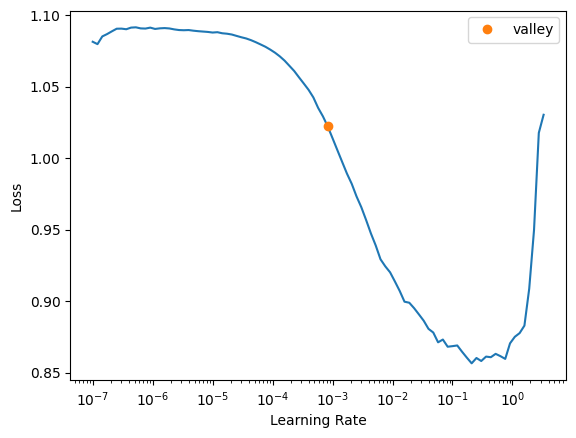

In [42]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

Train.

epoch,train_loss,valid_loss,accuracy,time
0,1.057145,1.098122,0.333333,00:00
1,1.023786,1.096391,0.333333,00:00
2,0.993733,1.089094,0.334444,00:00
3,0.964974,1.070788,0.357778,00:00
4,0.935692,1.049522,0.392222,00:00
5,0.905897,1.063037,0.400000,00:00
6,0.873975,1.219408,0.372222,00:00
7,0.841061,1.522874,0.358889,00:00
8,0.808006,1.443051,0.387778,00:00
9,0.776425,1.142480,0.506667,00:00


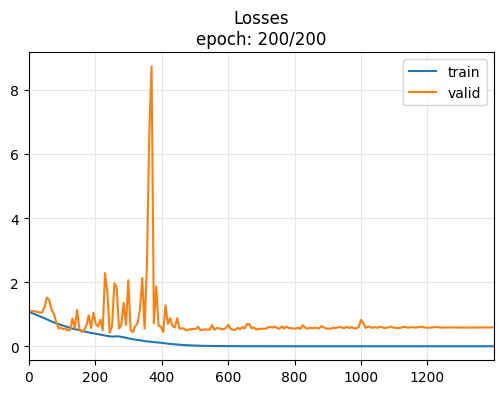

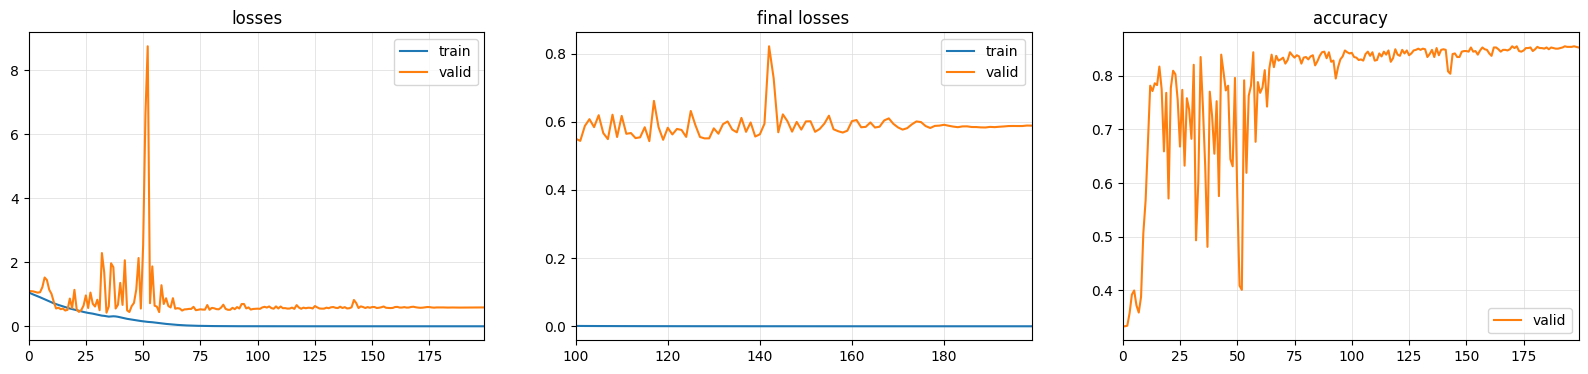

In [43]:
cache_file = f"./cache/tsai-dl-resnet-{data_hash}-{data_limit}.pkl"
if CACHING_ENABLED and os.path.exists(cache_file):
    print(f"Load previous trained ResNet from '{cache_file}' file.")
    with open(cache_file, "rb") as f:
        learn = pickle.load(f)
    model = learn.model
else:
    learn = ts_learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(n_epoch=200, lr_max=0.0017, cbs=ShowGraph())
    if CACHING_ENABLED:
        with open(cache_file, "wb") as f:
            pickle.dump(learn, f)

### Confusion matrix

In [44]:
from fastai.interpret import ClassificationInterpretation

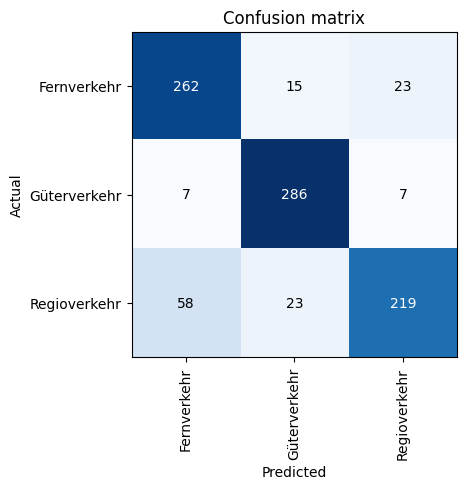

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [46]:
print("Most Confused:")
print(tabulate(np.array(interp.most_confused(min_val=1)).tolist(), headers=["Actual", "Predicted", "Amount"]))

Most Confused:


Actual        Predicted       Amount
------------  ------------  --------
Regioverkehr  Fernverkehr         58
Fernverkehr   Regioverkehr        23
Regioverkehr  Güterverkehr        23
Fernverkehr   Güterverkehr        15
Güterverkehr  Fernverkehr          7
Güterverkehr  Regioverkehr         7


Test on test set.

In [47]:
from sklearn.metrics import accuracy_score
from tsai.inference import get_X_preds  # noqa: F401  # patch learner with get_X_preds method

In [48]:
# on test sets
probas, target, preds = learn.get_X_preds(X[splits[2]], y[splits[2]])

In [49]:
model_score = accuracy_score(np.argmax(probas, axis=-1), target)
result_table_clf.append([model, round(model_score, 3)])
print(f"test score {model_score}")

test score 0.8633333333333333


## Final results comparison

In [50]:
print(
    tabulate(
        sorted([(cls.__class__.__name__, score) for cls, score in result_table_clf], key=lambda x: -x[1]),
        floatfmt=".3f",
        tablefmt="plain",
    )
)

MUSE                            0.870
ResNet                          0.863
RandomForestClassifier          0.763
ShapeletTransformClassifier     0.757
KNeighborsTimeSeriesClassifier  0.553
RidgeClassifierCV               0.450
KNeighborsClassifier            0.370
